In [68]:
# python native
import os
import json
import random
import datetime
from functools import partial

# external library
import cv2
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from sklearn.model_selection import GroupKFold
import albumentations as A

# torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models

# visualization
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp

In [69]:
CLASSES = [
    'finger-1', 'finger-2', 'finger-3', 'finger-4', 'finger-5',
    'finger-6', 'finger-7', 'finger-8', 'finger-9', 'finger-10',
    'finger-11', 'finger-12', 'finger-13', 'finger-14', 'finger-15',
    'finger-16', 'finger-17', 'finger-18', 'finger-19', 'Trapezium',
    'Trapezoid', 'Capitate', 'Hamate', 'Scaphoid', 'Lunate',
    'Triquetrum', 'Pisiform', 'Radius', 'Ulna',
]

CLASS2IND = {v: i for i, v in enumerate(CLASSES)}
IND2CLASS = {v: k for k, v in CLASS2IND.items()}

SAVED_DIR = "checkpoints"

model = smp.UnetPlusPlus(
    encoder_name="efficientnet-b7",        # 백본 네트워크
    encoder_weights="imagenet",    # 사전 학습 가중치
    in_channels=3,                 # 입력 채널 수 (RGB 이미지)
    classes=len(CLASSES)           # 출력 클래스 수
)


model = torch.load(os.path.join(SAVED_DIR, "./result_unet/unetPP_smp_800_1024.pt"))

IMAGE_ROOT = "./data/test/"

pngs = {
    os.path.relpath(os.path.join(root, fname), start=IMAGE_ROOT)
    for root, _dirs, files in os.walk(IMAGE_ROOT)
    for fname in files
    if os.path.splitext(fname)[1].lower() == ".png"
}

def encode_mask_to_rle(mask):
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


class XRayInferenceDataset(Dataset):
    def __init__(self, transforms=None):
        _filenames = pngs
        _filenames = np.array(sorted(_filenames))

        self.filenames = _filenames
        self.transforms = transforms

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, item):
        image_name = self.filenames[item]
        image_path = os.path.join(IMAGE_ROOT, image_name)

        image = cv2.imread(image_path)
        image = image / 255.

        if self.transforms is not None:
            inputs = {"image": image}
            result = self.transforms(**inputs)
            image = result["image"]

        # to tensor
        image = image.transpose(2, 0, 1)    # make channel first
        image = torch.from_numpy(image).float()

        return image, image_name

In [ ]:
import matplotlib.pyplot as plt

class_thresholds = {
    'Pisiform': 0.3,
    'Trapezoid': 0.3,
    # 나머지 클래스는 기본값을 사용
    'default': 0.5,
}

def test_with_tta_and_visualize(model, data_loader, tta_transforms):
    model = model.cuda()
    model.eval()
    
    rles = []
    filename_and_class = []
    visualized_count = 0 

    with torch.no_grad():
        for step, (images, image_names) in tqdm(enumerate(data_loader), total=len(data_loader)):
            images = images.cuda()

            # TTA 예측 생성
            outputs_list = []
            for i, tta_transform in enumerate(tta_transforms):
                tta_images = []
                for img in images:
                    img_np = img.cpu().numpy().transpose(1, 2, 0)  # CHW -> HWC
                    augmented = tta_transform(image=img_np)["image"]  # TTA 적용
                    augmented = torch.from_numpy(augmented.transpose(2, 0, 1)).float()  # HWC -> CHW
                    tta_images.append(augmented)

                    # 시각화: 원본 이미지와 TTA 적용된 이미지 비교
                    if visualized_count < 10:
                        plt.figure(figsize=(10, 5))
                        plt.subplot(1, 2, 1)
                        plt.imshow(img_np)
                        plt.title("Original Image")
                        plt.axis("off")

                        plt.subplot(1, 2, 2)
                        plt.imshow(augmented.numpy().transpose(1, 2, 0))  # CHW -> HWC
                        plt.title(f"TTA Applied: Transform {i+1}")
                        plt.axis("off")
                        plt.show()

                        visualized_count += 1

                        # 시각화 10장 이후 종료
                        if visualized_count >= 10:
                            break

                tta_images = torch.stack(tta_images).cuda()
                outputs = model(tta_images)
                outputs_list.append(outputs)

            # TTA 결과 평균
            outputs = torch.mean(torch.stack(outputs_list), dim=0)

            # 원본 크기로 복원
            outputs = F.interpolate(outputs, size=(2048, 2048), mode="bilinear")
            outputs = torch.sigmoid(outputs)
            # outputs = (outputs > thr).detach().cpu().numpy()

            # 클래스별 threshold 적용
            for output, image_name in zip(outputs, image_names):
                for c, segm in enumerate(output):  # 각 클래스마다 처리
                    class_name = IND2CLASS[c]
                    thr = class_thresholds.get(class_name, class_thresholds['default'])  # 클래스별 threshold 가져오기

                    # Tensor -> NumPy 변환 후 astype 사용
                    binary_mask = (segm > thr).cpu().numpy().astype(np.uint8)  # threshold 적용
                    rle = encode_mask_to_rle(binary_mask)
                    rles.append(rle)
                    filename_and_class.append(f"{class_name}_{image_name}")


    return rles, filename_and_class

tta_transforms = [
    A.Compose([A.Resize(1024, 1024)]),  # 기본 Resize
    # A.Rotate(limit=15, p=0.3),
    # A.HorizontalFlip(p=0.5),
    # A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=1.0),
    # A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.2),
    # A.CLAHE(clip_limit=(1, 4), tile_grid_size=(8, 8), p=0.5)
]

test_dataset = XRayInferenceDataset(transforms=A.Resize(1024, 1024))

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=2,
    shuffle=False,
    num_workers=2,
    drop_last=False
)

  0%|          | 0/144 [00:00<?, ?it/s]

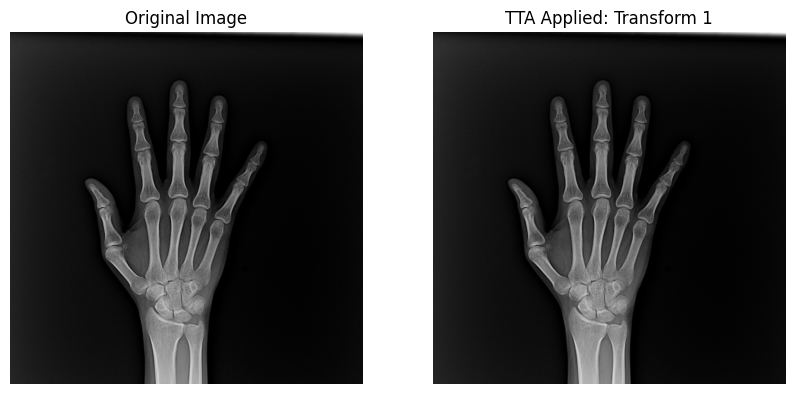

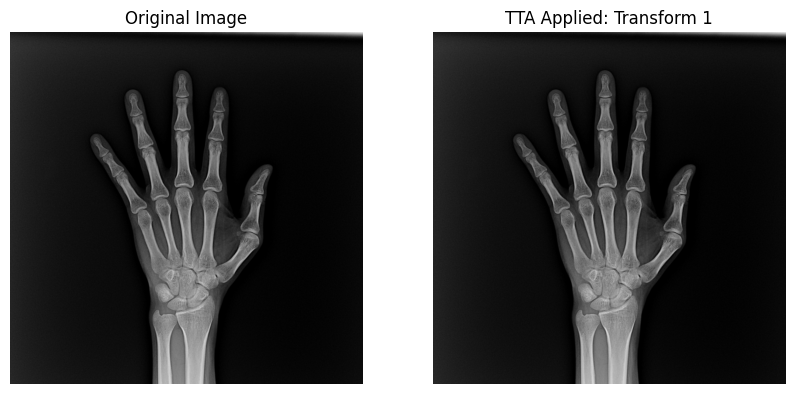

  1%|          | 1/144 [00:02<05:38,  2.37s/it]

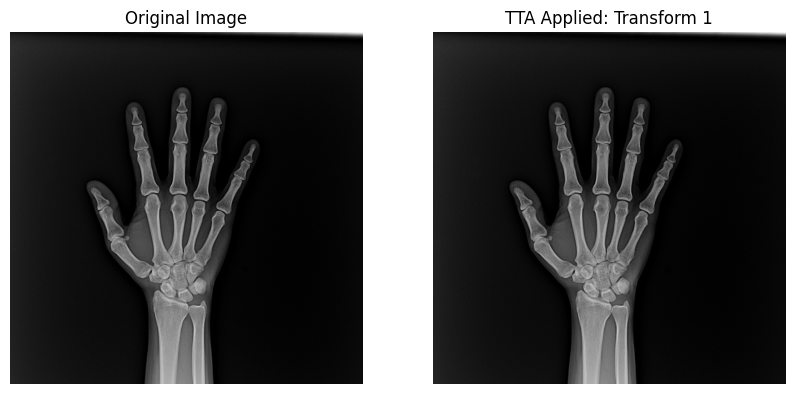

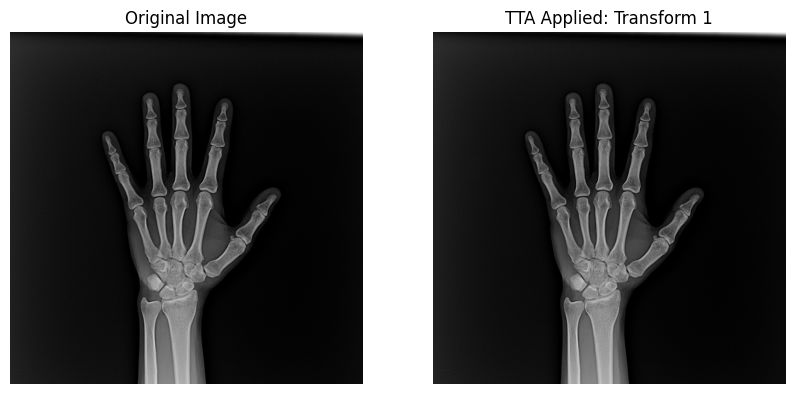

  1%|▏         | 2/144 [00:04<05:05,  2.15s/it]

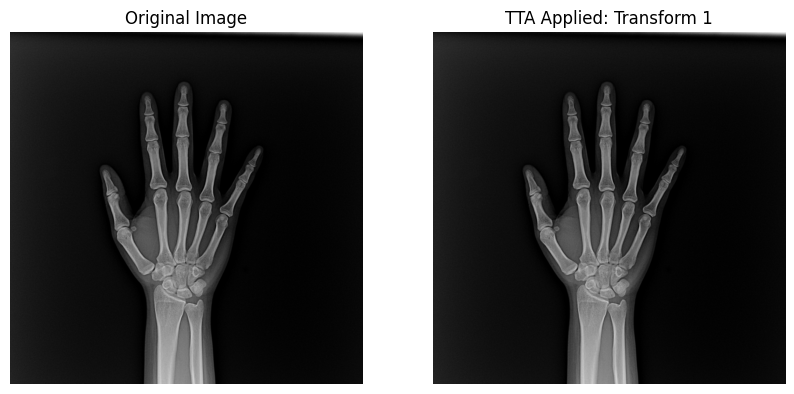

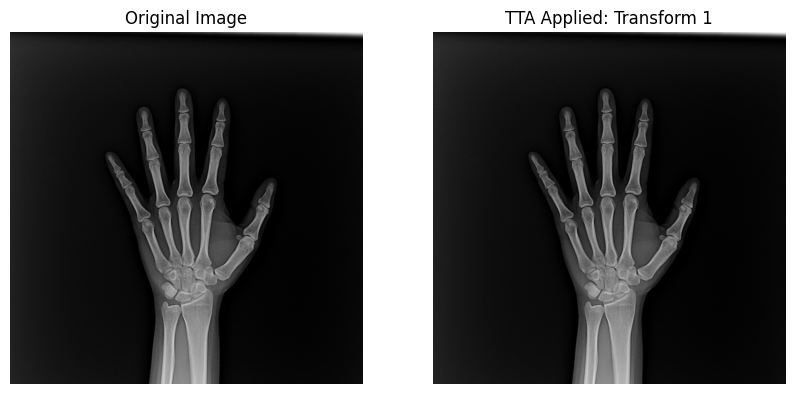

  2%|▏         | 3/144 [00:06<04:52,  2.07s/it]

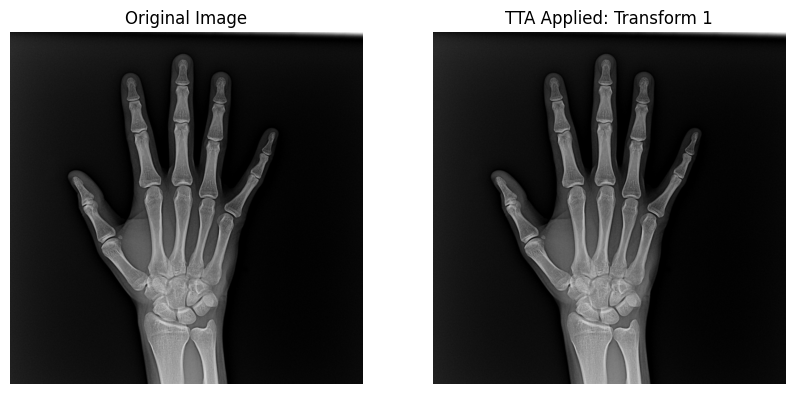

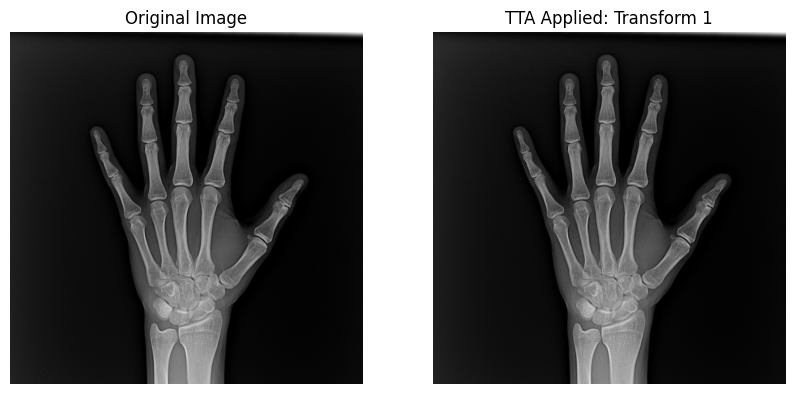

  3%|▎         | 4/144 [00:08<04:44,  2.04s/it]

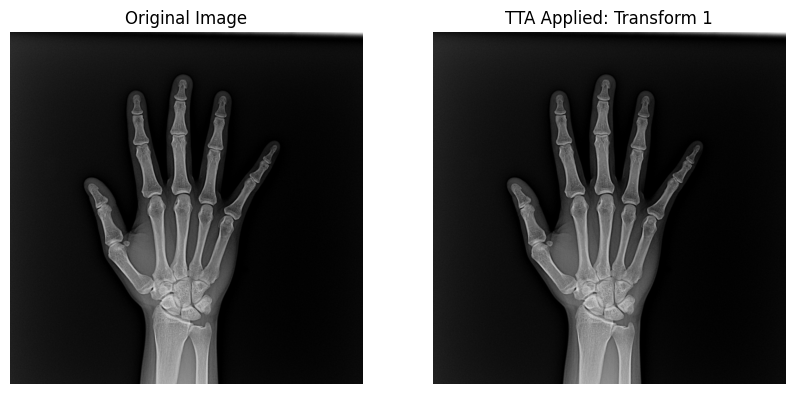

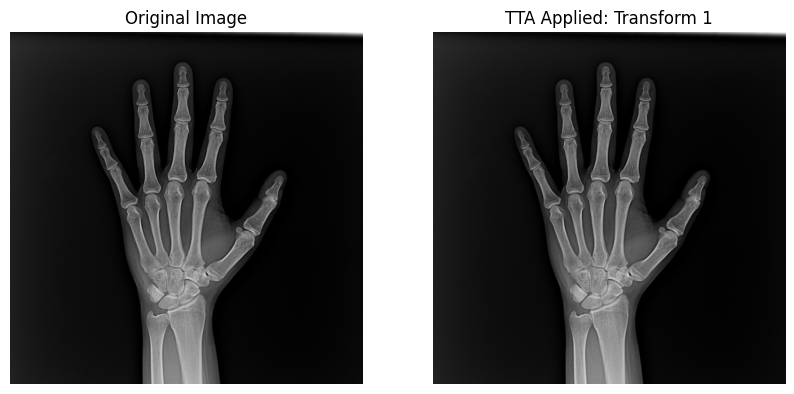

100%|██████████| 144/144 [02:49<00:00,  1.18s/it]


In [73]:
rles, filename_and_class = test_with_tta_and_visualize(model, test_loader, tta_transforms)

# 결과 저장
classes, filename = zip(*[x.split("_") for x in filename_and_class])

image_name = [os.path.basename(f) for f in filename]

df = pd.DataFrame({
    "image_name": image_name,
    "class": classes,
    "rle": rles,
})

df.to_csv("unetpp_tta_03.csv", index=False)